## Resampling/Permutation Tests

With **resampling**, you draw repeated samples from observed data with the goal of assessing random variability in a statistic. Similar to the bootstrap, you are not going to try to analytically determine the distribution of the test statistic, but instead build it out of the observed sample.

**The Big Idea:** We are trying to determine if two samples came from the same underlying distribution. If they came from the same distribution, then the label is irrelevant, and if we shuffle them, then it is still a sample from the same distribution.

You start with the null hypothesis - that the two samples came from the same distribution, and then look at the distribution of some test statistic (eg. difference in means) by randomly permuting the samples a large number of times and recalculating the test statistic.

That is, the $p$-value is the proportion of test statistics calculated from permutations that were _at least as extreme_ as the observed test statistic.

This is a non-parametric method, since you don't care how the data was generated (i.e., it doesn't matter if it was from a normal distribution).

See: http://faculty.washington.edu/yenchic/18W_425/Lec3_permutation.pdf

Let's look at the example with the amount of time spent sleeping. First, capture the observed difference in means.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sleeping = pd.read_csv('../data/atus_sleeping.csv')

In [3]:
observed_difference = sleeping[sleeping.sex == 'Female'].minutes_spent_sleeping.mean() - sleeping[sleeping.sex == 'Male'].minutes_spent_sleeping.mean()
observed_difference

62.72000000000003

Now, you will randomly shuffle the sex labels and see what the distribution of differences looks like.

In [4]:
num_Female = len(sleeping[sleeping.sex == 'Female'])
sleep_times = sleeping.minutes_spent_sleeping.tolist()

In [5]:
from nssstats.permutation import generate_permutations, permutation_test_p, permutation_test_plot

In [6]:
permutation_differences = generate_permutations(values = sleep_times, 
                                               label_count = num_Female,
                                               num_permutations = 10000,
                                               statistic = np.mean)

/home/michael/Documents/NSS_Work/stats-for-data-science/notebooks/nssstats/permutation.py:56: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = 'Observed\n Difference', xy = (observed_difference, 0),


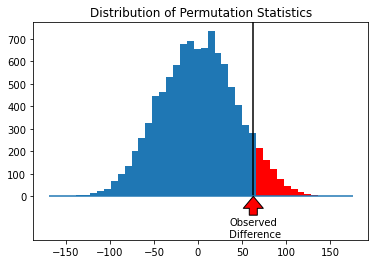

In [7]:
permutation_test_plot(permutation_differences, observed_difference, alternative = 'larger')

In [8]:
permutation_test_p(permutation_differences, observed_difference, alternative = 'larger')

0.0804

**Question:** What is our conclusion?

Now, repeat this for the grooming dataset.

In [9]:
grooming = pd.read_csv('../data/atus_grooming.csv')
observed_difference = grooming[grooming.sex == 'Female'].minutes_spent_grooming.mean() - grooming[grooming.sex == 'Male'].minutes_spent_grooming.mean()
observed_difference

20.68

In [10]:
num_Female = len(grooming[grooming.sex == 'Female'])
grooming_times = grooming.minutes_spent_grooming.tolist()

In [11]:
permutation_differences = generate_permutations(values = grooming_times,
                                                label_count = num_Female,
                                                statistic = np.mean)

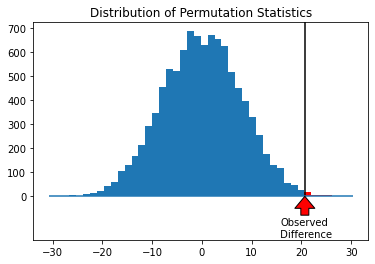

In [12]:
permutation_test_plot(permutation_differences, observed_difference, alternative = 'larger')

In [13]:
permutation_test_p(permutation_differences, observed_difference, alternative = 'larger')

0.0035

**Question:** What is our conclusion?

## Permutation Testing of Correlation

Let's see how to conduct a hypothesis test about correlation. We'll step through the example from the slides. Recall that the null and alternative hypotheses were

$$H_0: \text{The correlation between temperature and NOx concentration is 0}$$

$$H_1: \text{There is a negative correlation between temperature and NOx concentration.}$$

Read in the data.

In [14]:
air_quality = pd.read_csv('../data/air_quality.csv')

In [15]:
air_quality.head()

,Date,Temperature,NOx
0,22/03/2005,20.2,473.0
1,11/07/2004,29.5,32.0
2,29/05/2004,22.9,61.0
3,28/11/2004,11.2,60.0
4,02/06/2004,21.7,62.0


The scatterplot of the two relevant variables: `Temperature` and `NOx`

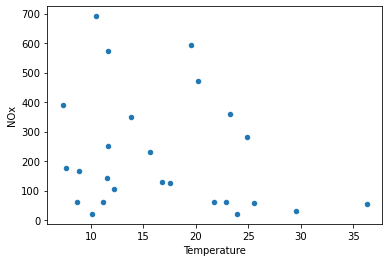

In [16]:
air_quality.plot(kind = 'scatter', x = 'Temperature', y = 'NOx');

The observed correlation:

In [17]:
np.corrcoef(air_quality['Temperature'], air_quality['NOx'])

array([[ 1.        , -0.24157135],
       [-0.24157135,  1.        ]])

In [18]:
observed_correlation = np.corrcoef(air_quality['Temperature'], air_quality['NOx'])[0,1]

To conduct the permutation test, you can first generate the permutations using the generate_permutations_correlation function from nssstats.permutations.

In [19]:
from nssstats.permutation import generate_permutations_correlation

To use this function, you need to pass in the two columns on interest as lists.

In [20]:
permutation_correlations = generate_permutations_correlation(air_quality['Temperature'].tolist(), 
                                                             air_quality['NOx'].tolist())

Now you can get the p-value and plot the permuted correlations.

/home/michael/Documents/NSS_Work/stats-for-data-science/notebooks/nssstats/permutation.py:56: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = 'Observed\n Difference', xy = (observed_difference, 0),


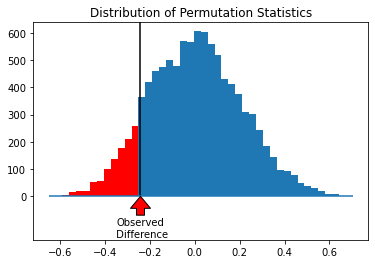

In [22]:
permutation_test_plot(permutation_correlations, observed_correlation, alternative = 'smaller')

In [21]:
permutation_test_p(permutation_correlations, observed_correlation, alternative = 'smaller')

0.1143

**Question:** What is our conclusion?